# Vacation Cabin Rental Revenue Management Example

### Introduction

Revenue management (RM) synchronizes market segmentation, optimal pricing, and optimal capacity usage to maximize revenues attainable through existing capacity. In this notebook we will demonstrate the impact of optimizing capacity allocation in a cabin rental context. In this scenario, we have several luxury properties at a mountain lake resort that we rent out: 

* 3 Small Cabins
* 5 Medium Cabins
* 3 Large Cabins. 

We will assume that we have already determined the best prices and have an accurate demand forecast for the upcoming weekend. We will compare three distinct capacity allocation policies against one another to see the impact on revenues:

* **Optimization:** Optimal demand fulfillment according to the demand forecast

* **First Come, First Served:** A human-like policy that fulfills requests as they come in, rather than optimally matching capacity to forecasted demand ahead of time.

As a preliminary, we import the necessary libraries:

In [1]:
# Import necessary libraries.
from pulp import *
import pandas as pd
import numpy as np
import random as rnd
import functools as ft
import matplotlib.pyplot as plt
import pprint

### Step 1: Load/Specify and View Data
Next we load our demand and price data, define our current capacity of each cabin type, and view the data:

In [2]:
# Load/set up the data
demand_data = pd.read_csv('DemandData.csv')
price_data = pd.read_csv('PriceData.csv')
available_units = {'Small':3, 'Medium':5, 'Large':3}

# View the demand data
demand_data

Rental Period  Small  Medium  Large
0       Fri-Sat      1       2      0
1       Fri-Sun      2       2      1
2       Fri-Mon      0       1      0
3       Sat-Sun      1       0      0
4       Sat-Mon      3       0      0
5       Sun-Mon      2       0      1
6       Mon-Wed      2       0      1

In [3]:
# View the price data
price_data

Rental Period    Small   Medium    Large
0       Fri-Sat   607.18  1195.98  2531.82
1       Fri-Sun   956.97  1884.97  3990.37
2       Fri-Mon  1214.36  2391.96  5063.64
3       Sat-Sun   607.18  1195.98  2531.82
4       Sat-Mon   956.97  1884.97  3990.37
5       Sun-Mon   607.18  1195.98  2531.82
6       Mon-Wed   607.18  1195.98  2531.82

### Step 2: Implement the Optimization Model and Solve
To solve this problem optimally, we will formulate and solve an integer programming (IP) model. We use the PuLP framework for doing this. The function below will construct an IP model instance from the given input data.

In [4]:
# This function constructs a PuLP integer programming model instance from the model inputs.
# @param T: A list of distinct resource types
# @param S: A list of distinct rental demand slots
# @param r: A dict of form {<demand slot>:<revenue per unit>}
# @param d: A dict of form {<demand slot>:<demand (in units)>}
# @param c: A dict of form {(<demand slot j>,  <demand slot k>): 0 | 1} where 1 designates that k overlaps j's start day 
# @param u: A dict of form {(<resource type>, <demand slot>): 0 | 1} where 1 = resource can satisfy demand slot; 0 otherwise
# @param A: A dict of form {<resource type>:<units available>}
# @param big_M: A large constant
# @returns: A PuLP Problem instance
def build_model(T, S, r, d, c, u, A, big_M):
    # Decision Variables:
    x = LpVariable.dicts("x", (T, S), 0, None, LpInteger)
    
    # Model declaration and objective function:
    prob = LpProblem("RentalRevMgmt", LpMaximize)
    prob += lpSum([r[j] * x[i][j] for i in T for j in S]), 'TotalRevenue'
    
    # Constraints:
    for j in S:
        # Don't assign more resources than demand to any slot:
        prob += lpSum([x[i][j] for i in T]) <= d[j] 
        for i in T:
            # Don't overbook any resources:
            prob += x[i][j] + lpSum([c[j,k] * x[i][k] for k in set(S).difference([j])]) <= A[i] 
            prob += x[i][j] <= big_M * u[i,j]  # Don't assign any resource type to slots it cannot satisfy
    return prob    

Now that we have the model formulated, we need to solve it and obtain the optimal sales plan and corresponding revenue attained. We will create an optimize function to do this. As a pre-requisite, we first need to connstruct a few helper functions to transform the raw data into the format needed by the model

In [5]:
# This utility function constructs a start day overlap matrix between every possible pair of distinct rental periods.
# @param distinct_rental_periods: A list of possible rental periods. Each period is of the form 
#                                "<Start Day>-<End Day>" or "<Start Day>-<End Day>: <Resource Type Required>"
# @returns: A dict of form {(<rental period j>, <rental period k>): 0 | 1}, where 1 designates that k overlaps j's start day
def build_start_day_overlap_matrix(distinct_rental_periods):
    week = ['Sun', 'Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat']
    day_inds = lambda days: dict([(day, i) for i, day in enumerate(days)])
    week_starting_on = lambda day: week[day_inds(week)[day]:] + week[:day_inds(week)[day]]
    interval = lambda s, e: week_starting_on(s)[:day_inds(week_starting_on(s))[e] + 1]
    matrix = {}
    days = lambda p: [p[:3], p[3:6]]
    for start_1, end_1, period_1 in [days(x) + [x] for x in distinct_rental_periods]:
        for start_2, end_2, period_2 in [days(x) + [x] for x in distinct_rental_periods]:
            matrix[(period_1, period_2)] = 1 if start_1 in interval(start_2, end_2) else 0
    return matrix

# This function builds the optimization model inputs from the raw data.
# @param demand_data: A pandas DataFrame containing the demand data in the spreadsheet format
# @param price_data: : A pandas DataFrame containing the price data in the spreadsheet format
# @param resource_availabilities: A dict of form {<resource type>:<units available>}
# @param valid_substitutions: A list of form [(<resource type A>, <resource type B>), ...] where A can sub for B
# @param big_M: A large constant
# @returns: a tuple of inputs of form (T, S, r, d, c, u, A, big_M)
def build_model_inputs(demand_data, price_data, resource_availabities, 
                       valid_substitutions, big_M):
    T = list(demand_data.columns)[1:]
    rental_periods = [x.replace('-', '') for x in list(demand_data.iloc[0:len(demand_data), 0])]
    resource_col_ind = {'Small':1, 'Medium':2, 'Large':3}
    period_row_ind = {period:ind for ind, period in enumerate(rental_periods)}
    S = [str(period) + str(resource) for resource in T for period in rental_periods]
    d = {str(p) + str(r): demand_data.iloc[period_row_ind[p], resource_col_ind[r]] 
         for r in T for p in rental_periods}
    r = {str(p) + str(r):price_data.iloc[period_row_ind[p], resource_col_ind[r]] 
         for r in T for p in rental_periods}
    A = resource_availabities
    c = build_start_day_overlap_matrix(S)
    subs = valid_substitutions + [(r, r) for r in T]
    u = {(r, str(p) + str(rp)): 1 if (r, rp) in subs else 0 
         for r in T for rp in T for p in rental_periods}
    return T, S, r, d, c, u, A, big_M
    
# This function uses the model to optimize the allocation of resources available to demands. Uses the
# CBC solver that comes with PuLP to solve the model.
# @param demand_data: A pandas DataFrame containing the demand data in the spreadsheet format
# @param price_data: : A pandas DataFrame containing the price data in the spreadsheet format
# @param resource_availabilities: A dict of form {<resource type>:<units available>}
# @param valid_substitutions: A list of form [(<resource type A>, <resource type B>), ...] where A can sub for B
# @returns: A tuple of form (<pandas DataFrame>, <total revenue>). The data frame is the capacity allocation/sales plan.
def optimize(demand_data, price_data, resource_availabities, valid_substitutions):
    big_M = 1 + sum(resource_availabities.values())
    model_inputs = build_model_inputs(demand_data, price_data, resource_availabities, 
                                      valid_substitutions, big_M)
    model = build_model(*model_inputs)
    model.solve() 
    resources, slots, assignments = [], [], []
    for v in model.variables():
        if v.name.startswith('x'):
            var, i, j, val = v.name.split('_') + [v.varValue]
            if val > 0:
                resources.append(i)
                slots.append(j)
                assignments.append(val)
    return pd.DataFrame({'Resource':resources, 'Demand Slot':slots, 
                         'Units Allocated':assignments}), value(model.objective)  

Now we can use this to get an optimal sales plan and see the resulting revenues:

In [6]:
valid_substitutions = [('Large', 'Small'), ('Large', 'Medium'), ('Medium', 'Small')]
plan_OPT, revenue_OPT = optimize(demand_data, price_data, available_units, valid_substitutions)
print("Total Revenue Attained: ${:,}".format(round(revenue_OPT, 2)))
plan_OPT

Total Revenue Attained: $24,471.65


Resource   Demand Slot  Units Allocated
0     Large  FriSatMedium              1.0
1     Large   FriSunLarge              1.0
2     Large   FriSunSmall              1.0
3     Large   MonWedLarge              1.0
4     Large   SunMonLarge              1.0
5    Medium  FriMonMedium              1.0
6    Medium  FriSatMedium              1.0
7    Medium   FriSatSmall              1.0
8    Medium  FriSunMedium              2.0
9    Medium   MonWedSmall              2.0
10   Medium   SunMonSmall              2.0
11    Small   SatMonSmall              3.0

### Step 3: Solving the Human Way - First Come, First Served

To provide comparison, we will implement a first-come-first-served (FCFS) algorithm to mimic the way a human agent not using RM would most likely allocate the capacity. In FCFS, booking requests are served as they come in if there is available capacity to meet them. Substituting larger cabins for smaller is not used since, without a demand forecast, we would not know whether the next request might be for a larger, higher-paying cabin.

In the code below, we also include a data pre-processing function to transform the raw data into the form needed by the FCFS algorithm. The pre-processing function randomly orders the booking requests in order to simulate the way they come in the real world.

In [7]:
# This function builds formatted inputs for the FCFS heuristic from the raw data. It simulates the real world
# by randomly ordering the requests for rental units.
# @param demand_data: A pandas DataFrame containing the demand data in the spreadsheet format
# @param price_data: : A pandas DataFrame containing the price data in the spreadsheet format
# @param resource_availabilities: A dict of form {<resource type>:<units available>}
# @returns: A tuple of required inputs in form (T, S, r, d, c, A)
def build_FCFS_inputs(demand_data, price_data, resource_availabities):
    T, S, r, d, c, _, A, _ = build_model_inputs(demand_data, price_data, 
                                                resource_availabities, [], 0)
    formatted_d = ft.reduce(lambda x, y: x + y, [[s for i in range(dmd)] for s, dmd in d.items()])
    rnd.shuffle(formatted_d)
    conflict_matrix = {(j, k): 1 if c[j,k] + c[k,j] > 0 else 0 for (j, k) in c.keys()}
    return T, S, r, formatted_d, conflict_matrix, A
    
# This heuristic approximates the way a human might allocate the available units to the demand. It fulfills demand 
# on a first-come-first-served basis with exactly the requested resource (versus the requested or better). The
# fulfillment plan and resulting reveue is largely dependent on the order in which the slots are requested.
# @param T: A list of distinct resource types
# @param S: A list of distinct rental demand slots. 
# @param r: A dict of form {<demand slot>:<revenue per unit>}
# @param d: A list of rental demand slots. Each demand slot corresponds to one unit of demand. 
#           The same demand slot can occur multiple times, corresponding to multiple demand requests.
# @param c: A dict of form {(<demand slot>,  <demand slot>): 0 | 1} where 1 = conflict between slots; 0 = no conflict
# @param A: A dict of form {<resource type>:<units available>}
# @returns: A tuple of form (<pandas DataFrame>, <total revenue>). The data frame is the capacity allocation/sales plan.
def solve_FCFS(T, S, r, d, c, A):
    resource = lambda j: [i for i in T if j.endswith(i)][0]
    slot_resources_available = {j:A[resource(j)] for j in S}
    revenue = 0
    plan = {j:0 for j in S}
    for j in d:
        if slot_resources_available[j] > 0:
            keys = [(x, y) for (x, y) in c.keys() 
                    if j == x and y in slot_resources_available and y.endswith(resource(j))]
            for _, k in keys:
                if c[j, k] == 1:
                    slot_resources_available[k] -= 1
            plan[j] += 1
            revenue += r[j]
    plan = {j:plan[j] for j in plan.keys() if plan[j] > 0}
    resources, slots, assignments = [], [], []
    for slot, allocation in plan.items():
        resources.append(slot[6:])
        slots.append(slot)
        assignments.append(allocation)
    return pd.DataFrame({'Resource':resources, 'Demand Slot':slots, 
                         'Units Allocated':assignments}), revenue 

### Step 4: Compare Optimization with FCFS

Below we will compare two variations of optimization (one with no substitutions, and one that allows larger cabins to sub for smaller ones) against FCFS to see the impact on our revenues. We will run FCFS 100 times, randomly ordering the booking requests in each case, and compare the worst, median (i.e. typical), and best cases to the two optimization results.

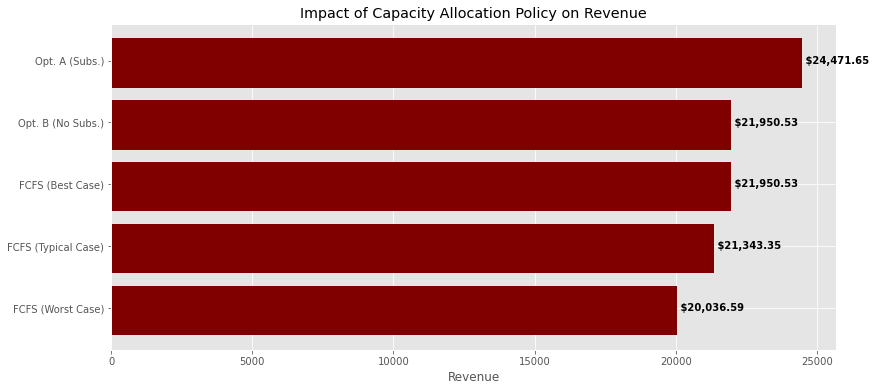

In [8]:
# Policy 1: Optimization A (substituting larger cabins for smaller ones allowed)
valid_substitutions = [('Large', 'Small'), ('Large', 'Medium'), ('Medium', 'Small')]
_, revenue_OPT_subs = optimize(demand_data, price_data, 
                               available_units, valid_substitutions)
    
# Policy 2: Optimization B (no cabin substitutions)
no_subs = []
_, revenue_OPT_no_subs = optimize(demand_data, price_data, available_units, no_subs)

# Policy 3: FCFS - run 100 times using randomly-ordered data and collect the results
rnd.seed(2159) # This will allow the randomized results to be reproduced.
FCFS_results = []
for i in range(100):
    Fi = build_FCFS_inputs(demand_data, price_data, available_units)
    FCFS_results.append(solve_FCFS(*Fi)[1])

# Construct a bar chart of the results:
plt.style.use('ggplot')

x = ['FCFS (Worst Case)', 'FCFS (Typical Case)', 'FCFS (Best Case)',
     'Opt. B (No Subs.)', 'Opt. A (Subs.)']
y = [min(FCFS_results), np.median(FCFS_results), max(FCFS_results), 
     revenue_OPT_no_subs, revenue_OPT_subs]

fig, ax = plt.subplots(figsize = (13, 6))   
width = 0.8 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="maroon", align='center')
ax.set_yticks(ind+width/20)
ax.set_yticklabels(x, minor=False)
for i, v in enumerate(y):
    ax.text(v, i, str(" ${:,}".format(round(v, 2))), 
            color='black', fontweight='bold')
plt.title('Impact of Capacity Allocation Policy on Revenue')
plt.xlabel('Revenue')
plt.ylabel('')      
plt.show()

We see that FCFS will typically leave revenue on the table - and if we get unlucky, this can be a significant amount. Only in the best case will FCFS reach the maximum revenue possible under the assumption of no substitutions allowed (which is always reached by the Optimization B policy). By allowing substitutions and optimizing, however, we attain a big boost in revenues - amounting to an increase of more than 22% over the worst-case (or well over $4,000) for the weekend. Moreover, this extra revenue is earned using existing capacity without incurring any additional costs, so it is entirely profit. This comparison demonstrates the impact RM can make.